# Machine Learning Model to Predict Volatility of Biotech Catalysts

## Intro:
The goal was to build a half decent model that was able to predict, with some level of accuracy, whether catalyst events will be volatile or not. Note, the term *Volatile* simply denotes a greater than 10% total return two days after the catalyst event in either direction. So either a 10%/-10% total return. Features include the market capitalization of each first and the number of drugs in the pipeline. The these for engineering these two features was that smaller biotech companies, with smaller market capitalization and fewer drugs in the pipeline, will be more volatile around catalyst events. The drugCount variable, or the number of drugs in the pipeline, is an interesting feature because it could help the algo realize that if there is a high MC but low number of drugs in the pipeline then the event might still be volatile. 

## Notes:
One of the biggest problems with this dataset and each of the variables that were generated is that the data was pulled for the company as of today, not when the event occured. I still wanted to try to pull the data to see if there were possible predictive relationships, and there were. But it is important to understand that the MC and drug count in the dataset and indicitave of where the company is at now in terms of drug development and market capitalization. Both these variables could have been different when the actual event occured. 

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [3]:
data = pd.read_csv('catalystsMktCap.csv') # this has the MC data in it

Market Capitalization data is generated in another jupyter notebook, not replicated here because it takes 20 minutes to pull the data 

In [6]:
data = data.drop(['Unnamed: 0'],axis=1) # drops the Unnamed columns created by not removing the index when writing to csv 
data.head()

,Ticker,Drug,Indication,Date,Status,Day,Class,Volat,marketCap
0,AGRX,Twirla,Contraceptive patch,2017-01-03,Phase3,42,neg,1,254.435
1,AEZS,Macimorelin Acetate - Macrilen,Adult Growth Deficiency,2017-01-04,Phase3,43,neg,1,24.097
2,HALO,HALO-301,Pancreatic cancer,2017-01-05,Phase2,44,pos,1,5549.262
3,GNCA,GEN-003,Genital herpes,2017-01-05,Phase2b,44,na,0,112.565
4,OTIC,OTIPRIO,Acute otitis externa,2017-01-05,Phase3,44,na,0,261.394


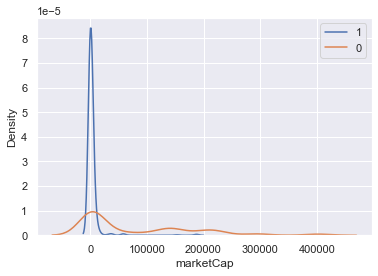

In [13]:
for i in data['Volat'].unique(): # graph the market cap and density of 1s and 0s (1: volatile,0:non-volatile)
    sns.distplot(data[data['Volat']==i]['marketCap'], hist=False,label=i)
    plt.legend()

The graph above demonstrates that marketCap is highly predictive of event outcome with a lot of volatile events occuring at a lower market cap. 

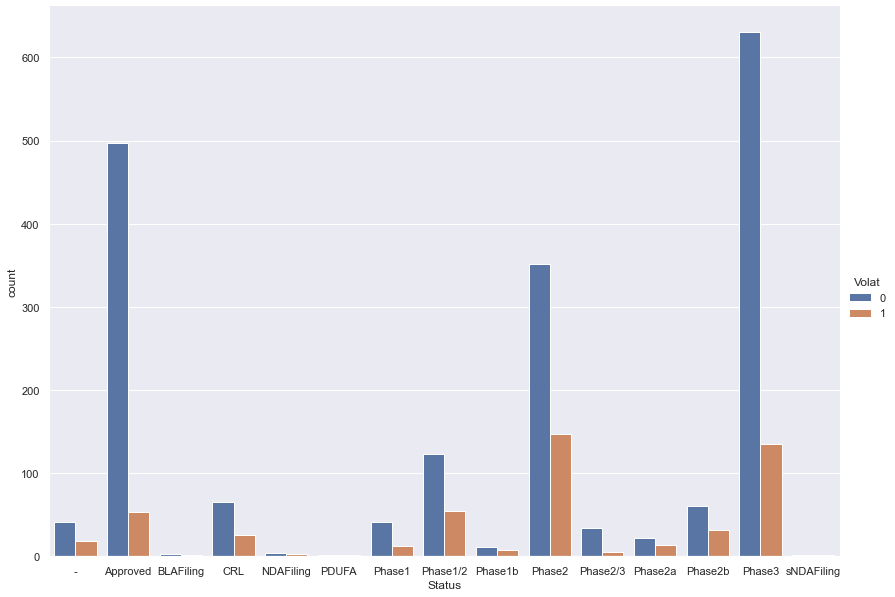

In [11]:
x,y = 'Status','Volat'
order = data.groupby(x)[y].count().index.tolist()

sns.catplot(x=x, hue=y, data=data, kind='count', order=order,height=8.27, aspect=11.7/8.27) # this is a graph to show the counts of different types of catalysts and the count of volatile events that occur in each one

In [14]:
data['Status'].value_counts() # values counts to see what the major datapoints are 

Phase3        765
Approved      550
Phase2        498
Phase1/2      178
Phase2b        92
CRL            91
-              60
Phase1         53
Phase2/3       39
Phase2a        35
Phase1b        19
NDAFiling       7
BLAFiling       4
PDUFA           3
sNDAFiling      2
Name: Status, dtype: int64

In [120]:
p1list = ['Phase1','Phase1/2','Phase1b']
p2list = ['Phase2','Phase2/3','Phase2a','Phase2b']
p3list = ['Phase3']

master = p1list + p2list + p3list

data1 = data.loc[data['Status'].isin(master)]

data1['p1'] = np.where(data1['Status'].isin(p1list),1,0)
data1['p2'] = np.where(data1['Status'].isin(p2list),1,0)
data1['p3'] = np.where(data1['Status'].isin(p3list),1,0)

Both CRLs and Approval events are removed because these outcomes are not known in advance. The only way it makes sense to include these would be under a regulatory 'basket' where the event outcome was really unknown. For this analysis, this was not done because I wanted to focus on the clinical trials. It is possible that the inclusion of these events could help to round out the dataset, could add as much as 600 new datapoints. 

In [122]:
data1 = data1.drop(['Drug','Indication','Status','Class'],axis=1)

In [123]:
data1

,Ticker,Date,Day,Volat,marketCap,p1,p2,p3
0,AGRX,2017-01-03,42,1,254.435,0,0,1
1,AEZS,2017-01-04,43,1,24.097,0,0,1
2,HALO,2017-01-05,44,1,5549.262,0,1,0
3,GNCA,2017-01-05,44,0,112.565,0,1,0
4,OTIC,2017-01-05,44,0,261.394,0,0,1
...,...,...,...,...,...,...,...,...
2385,AZN,2020-11-23,1022,0,142459.290,0,0,1
2386,BLRX,2020-11-23,1022,0,50.702,0,1,0
2387,ARQT,2020-11-23,1022,0,1258.855,0,1,0
2388,BLPH,2020-11-23,1022,1,59.551,0,0,1


In [21]:
import requests
from bs4 import BeautifulSoup

In [24]:
uniSym = data['Ticker'].unique().tolist()

In [25]:
len(uniSym) # len of unique list

435

In [37]:
results = {} # this takes a long time to run
for symbol in uniSym:
    url = f'https://www.biopharmcatalyst.com/company/{symbol}'
    page = requests.get(url)
    soup = BeautifulSoup(page.content,'html.parser')
    drugs = soup.find_all('div', class_='drug-info__name')
    results[symbol] = len(drugs)

The above cell shows how the drugCount data was generated. BioPharmcatalyst has a simple URL where the end is the ticker for that page, at that URL there is a simple data structure that contains the drugs in their pipeline. If you were to just go to this url on a web browser they have it covered up; it is not concealed in the source code however. The code cell above just scrapes the names of the drugs and then measures the len, this is added to a dict called results. 

In [42]:
drugCount = [] # finds the drug count for each ticker in the list
for sym in data1['Ticker'].to_list():
    drugCount.append(results[sym])

In [125]:
data1['drugCount'] = drugCount # adds to the dataframe

In [126]:
data1

,Ticker,Date,Day,Volat,marketCap,p1,p2,p3,drugCount
0,AGRX,2017-01-03,42,1,254.435,0,0,1,1
1,AEZS,2017-01-04,43,1,24.097,0,0,1,3
2,HALO,2017-01-05,44,1,5549.262,0,1,0,10
3,GNCA,2017-01-05,44,0,112.565,0,1,0,3
4,OTIC,2017-01-05,44,0,261.394,0,0,1,6
...,...,...,...,...,...,...,...,...,...
2385,AZN,2020-11-23,1022,0,142459.290,0,0,1,87
2386,BLRX,2020-11-23,1022,0,50.702,0,1,0,7
2387,ARQT,2020-11-23,1022,0,1258.855,0,1,0,7
2388,BLPH,2020-11-23,1022,1,59.551,0,0,1,4


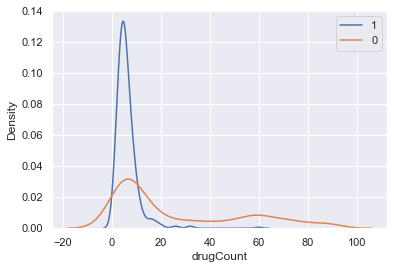

In [48]:
for i in data1['Volat'].unique():
    sns.distplot(data1[data1['Volat']==i]['drugCount'], hist=False,label=i)
    plt.legend()

This shows that the number of drugs in the pipeline is predictive of volatility; there are many more volatile events when there are fewer drugs in the pipeline.  

In [130]:
print('Mean of drugCount in companies that had Volatile Events: ' + str(round(data1.loc[data1['Volat'] == 1]['drugCount'].mean(),3))) # mean of volat events

Mean of drugCount in companies that had Volatile Events: 6.079


In [132]:
print('Mean of drugCount in companies that had non-Volatile Events:  ' + str(round(data1.loc[data1['Volat'] == 0]['drugCount'].mean(),3))) # mean of non-volat events 

Mean of drugCount in companies that had non-Volatile Events:  26.481


In [56]:
mlData = data1.drop(['Ticker','Date','Day'],axis=1)

In [133]:
mlData

,Volat,marketCap,p1,p2,p3,drugCount
0,1,254.435,0,0,1,1
1,1,24.097,0,0,1,3
2,1,5549.262,0,1,0,10
3,0,112.565,0,1,0,3
4,0,261.394,0,0,1,6
...,...,...,...,...,...,...
2385,0,142459.290,0,0,1,87
2386,0,50.702,0,1,0,7
2387,0,1258.855,0,1,0,7
2388,1,59.551,0,0,1,4


In [134]:
mlData.dtypes

Volat          int64
marketCap    float64
p1             int32
p2             int32
p3             int32
drugCount      int64
dtype: object

In [58]:
from sklearn import ensemble

In [67]:
mlData = mlData.dropna()

In [69]:
X = mlData.drop("Volat", axis=1).values
y = mlData["Volat"].values
feature_names = mlData.drop("Volat", axis=1).columns.tolist() # var names w/o targetLabels

model = ensemble.RandomForestClassifier(n_estimators=100, # set up model
                      criterion="entropy", random_state=0)
model.fit(X,y) # run models
importances = model.feature_importances_ # pull how important 

importDf = pd.DataFrame({"importance":importances, # add to df 
            "variable":feature_names})
importDf = importDf.set_index("variable") # set variable as index 

In [70]:
importDf

,importance
variable,
marketCap,0.683518
p1,0.007176
p2,0.008757
p3,0.011709
drugCount,0.288840


drugCount and marketCap are the two most predictive variables. 

In [71]:
mlData.head() # just shows what columns are in the mlData df

,Volat,marketCap,p1,p2,p3,drugCount
0,1,254.435,0,0,1,1
1,1,24.097,0,0,1,3
2,1,5549.262,0,1,0,10
3,0,112.565,0,1,0,3
4,0,261.394,0,0,1,6


In [73]:
trainingData,testingData = mlData[:int(round(len(mlData.index) * 0.7,0))],mlData[int(round(len(mlData.index) * 0.7,0)):] # split the data into training data and testing data, ratio 0.7:0.3

In [102]:
finalVar = [a for a in trainingData.columns if a != 'Volat'] # all columns but Volat
# training data 
xTrain = trainingData[finalVar].values 
yTrain = trainingData['Volat'].values

# testing data 
xTest = testingData[finalVar].values
yTest = testingData['Volat'].values

In [103]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier() # gradient boosting classifier model
clf.fit(xTrain,yTrain) # train model
predictions = clf.predict(xTest)
print(classification_report(yTest,predictions))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82       359
           1       0.47      0.15      0.23       144

    accuracy                           0.71       503
   macro avg       0.60      0.54      0.52       503
weighted avg       0.66      0.71      0.65       503



In [104]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(yTest,predictions))

[[334  25]
 [122  22]]


The classification report and confusion matrix above show that this is a decent model for a first try. Other features should be added to improve accuracy. It looks like the models is really good at predicting non=volatile (0) events, this makes sense because the dataset has more 0 than 1 events. Most of the error in the model comes from events that are falsy classified as 1 events but are really 0 events. Overall accuracy was 0.71 pct. 

In [107]:
clf = GradientBoostingClassifier() # gradient boosting classifier model
clf.fit(xTrain,yTrain) # train model
predictions = clf.predict(xTest)
print(classification_report(yTest,predictions))
print(confusion_matrix(yTest,predictions))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       359
           1       0.58      0.12      0.21       144

    accuracy                           0.72       503
   macro avg       0.66      0.54      0.52       503
weighted avg       0.69      0.72      0.65       503

[[346  13]
 [126  18]]


Note, dropping the number of drugs in the pipeline actually improves the algo. -- unclear why this is. The accuracy improved because it appears that removing the drugCount column made it easier to identify true 0 events, it also made the algo identify less 1 events correctly. I think more features are needed but then drugCount could be left in. 

## Conclusion:
marketCap and drugCount are predictive features that have allowed the construction of a preliminary model to predict volatility of catlayst events in this custom dataset. More feature engineering is needed before the model is complete but this is the first step. 

In [119]:
data1.to_csv('catalystDrugCount.csv')